# Overfitting and Regularization

## Imports

In [326]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [327]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [328]:
set_config(display='diagram')

## Settings

In [329]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [330]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

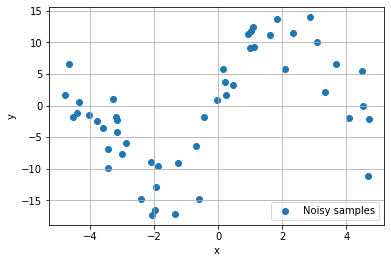

In [331]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

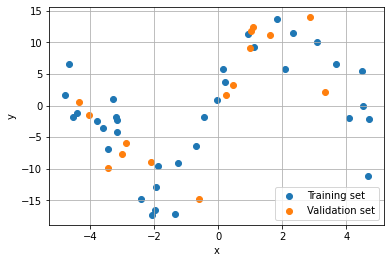

In [332]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [333]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [334]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [335]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

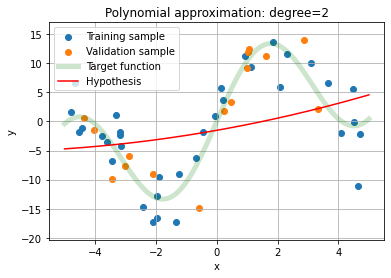

In [336]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

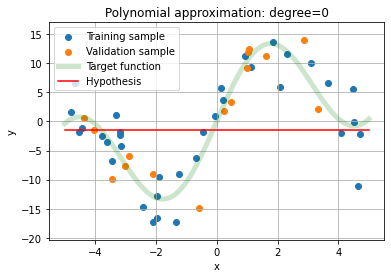

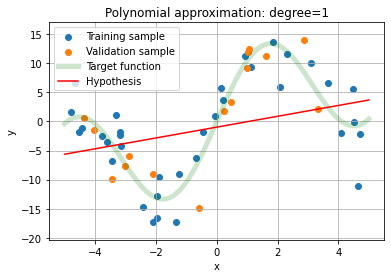

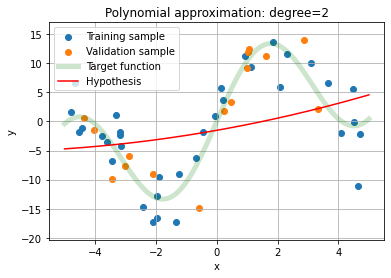

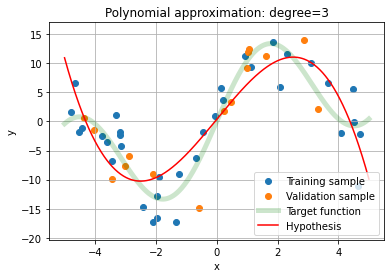

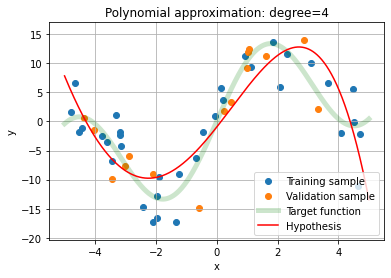

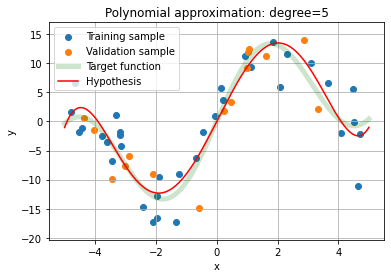

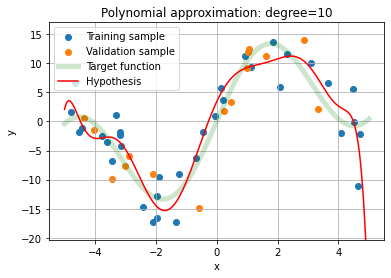

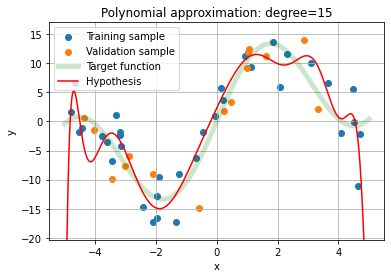

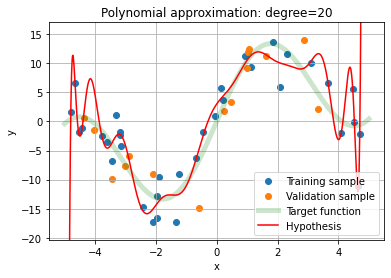

In [337]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

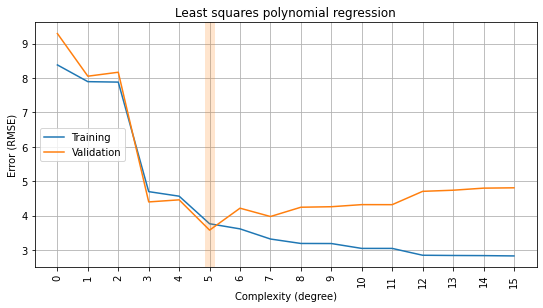

In [338]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [339]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

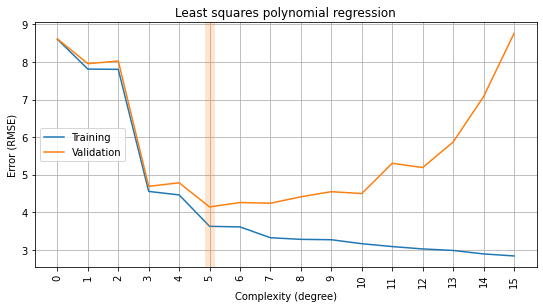

In [340]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [341]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

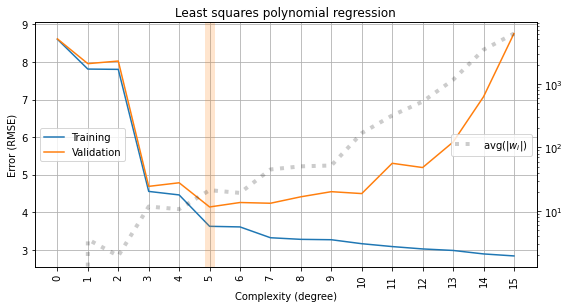

In [342]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

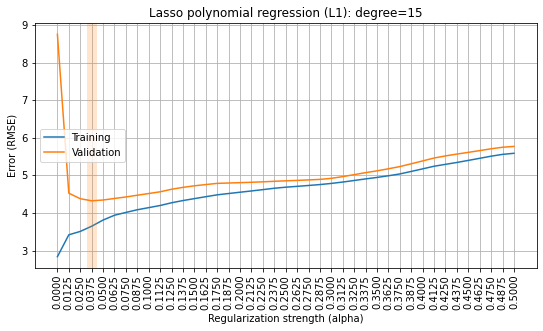

In [343]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

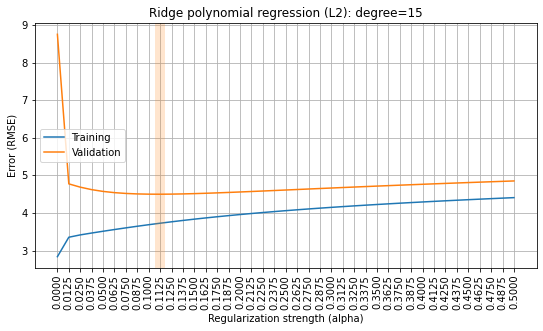

In [344]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [345]:
# из-за ограничений мощности создадим модель с выборкой признака. А после этого соберем все признаки вместе (тот, который использовался для генерации полиномов, и остальные).
def make_model_homework(degree, alpha=0, penalty=None, poly_feats=[4]):

    if alpha == 0:
        regressor = LinearRegression()

    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)

    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000)
    
    poly = PolynomialFeatures(degree, include_bias=(degree == 0))
    poly = ColumnTransformer([('poly', poly, poly_feats)], remainder='passthrough')
    return Pipeline([('poly', poly), ('sca', StandardScaler()), ('reg', regressor)])

In [346]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [347]:
#разделим датасет на тренировочные и тестовые данные (70% на 30%)
X_train, X_valid, y_train, y_valid = train_test_split(data['data'], data['target'], test_size=0.3, random_state = 42)

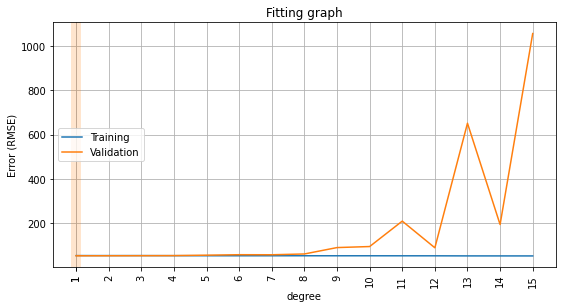

In [348]:
#построим график зависимости ошибки предсказания модели (RMSE) от степени полинома (degree)
#после полинома 8 - скачок вверх (для наглядности отражения зависимости ниже построим график без степеней >8)
DEGREES = np.linspace(1, 15, 1 + 15, dtype=int)
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model_homework(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='degree', ylabel='Error (RMSE)')

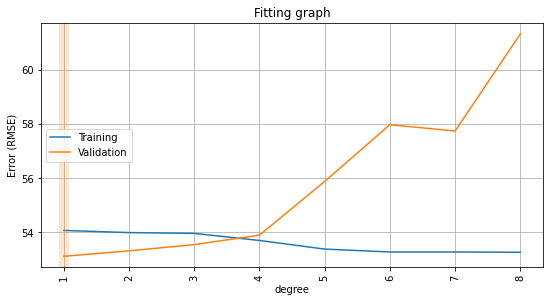

In [349]:
#график зависимости ошибки предсказания модели (RMSE) от степени полинома (degree) <=8
DEGREES = [1,2,3,4,5,6,7,8]
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model_homework(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='degree', ylabel='Error (RMSE)')

In [350]:
#оптимальная степень полинома
DEGREES[np.argmin(rmse_valid)]

1

Отмечается следующее:

- Оптимальный результат (степень = 1): В данном случае модель способна отразить основное распределение данных. Модель хорошо подходит как для обучающего, так и для проверочного набора. Можно говорить, о том что значения лежат на прямой линии;
- Переобучение (степень > 1): Модель начинает соответствовать шуму в наборе данных. В то время как соответствие для обучающих данных становится еще лучше, соответствие для проверочного набора ухудшается;
- Недообучение: не наблюдается.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [351]:
#ввиду ограниченных мощностей, проведем анализ влияния альфы на веса (коэффициенты модели) на примере одного признака (например 'bp')
def koef_L1(alpha):
  return make_model_homework(degree=15, alpha=alpha, penalty='L1').fit(X_train, y_train)['reg'].coef_

L1_coefs = np.array([koef_L1(alpha) for alpha in ALPHAS])

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.917e+02, tolerance: 1.900e+02
  model = cd_fast.enet_coordinate_descent(


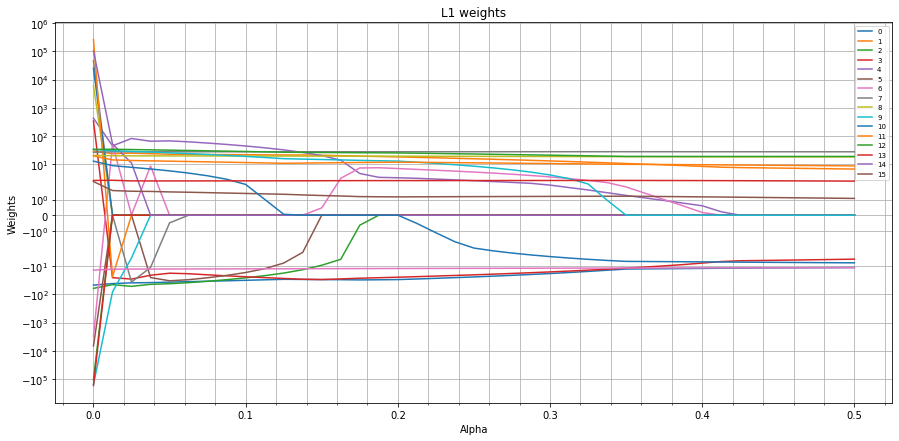

In [352]:
plt.figure(figsize=(15,7))
plt.yscale('symlog')
plt.xlabel('Alpha')
plt.ylabel('Weights')
plt.title('L1 weights')
plt.plot(ALPHAS, L1_coefs)
plt.legend(range(16), loc='best', fontsize=7)
plt.minorticks_on()
plt.grid(which='both')
plt.show()

#### L2

In [353]:
#аналогично для L2
def koef_L2(alpha):
  return make_model_homework(degree=15, alpha=alpha, penalty='L2').fit(X_train, y_train)['reg'].coef_

L2_coefs = np.array([koef_L2(alpha) for alpha in ALPHAS])

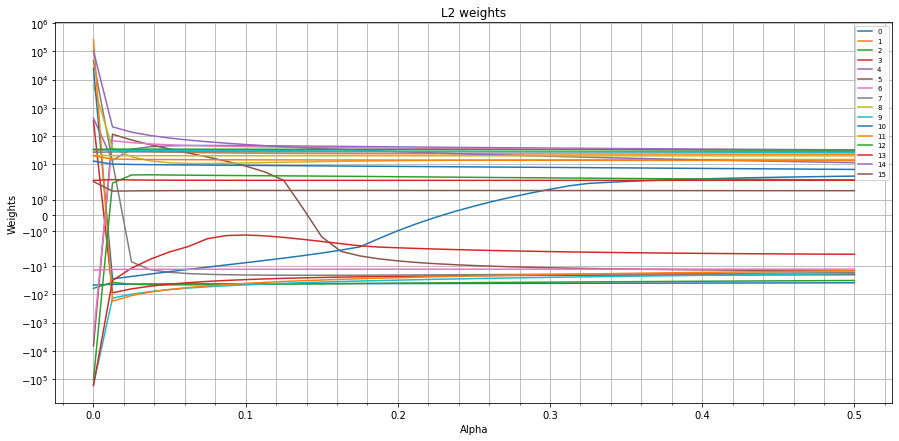

In [354]:
plt.figure(figsize=(15,7))
plt.yscale('symlog')
plt.xlabel('Alpha')
plt.ylabel('Weights')
plt.title('L2 weights')
plt.plot(ALPHAS, L2_coefs)
plt.legend(range(16), loc='best', fontsize=7)
plt.minorticks_on()
plt.grid(which='both')
plt.show()

#### Summary

Можно отметить следующее:
- Регуляризация влияет на веса модели (ограничивает их); 
- С увеличением коэффициента регуляризации веса признаков уменьшаются (в отдельных случаях до нуля или близко к нему);
- Таким образом применение регуляризации позволяет при построении моделей избежать переобучения и повысить качество предсказаний.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [355]:
#соединим в датафрэйм наши коэффициенты L1 и значения alpha
df_l1 = pd.DataFrame(L1_coefs, index=ALPHAS)
df_l1

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0.0000,-46.735870,29.459781,-61.104121,340.297923,429.265126,-6706.154224,-3076.335580,46559.422118,6098.617709,-158487.118634,...,104190.103474,2.416084,-13.739124,26.310922,20.551249,33.148749,12.817433,19.770863,33.607345,2.646955
0.0125,-41.409627,23.601244,-45.091524,-25.469602,44.764431,0.000000,51.016707,-0.000000,0.000000,-81.557617,...,52.249950,1.574509,-12.768891,27.450920,19.905153,30.039838,8.873758,14.162420,33.750945,2.682984
0.0250,-38.891039,24.648561,-51.823219,-28.576220,81.566958,-0.000000,0.017467,-36.477046,0.000000,-5.063400,...,10.965773,1.530672,-12.642994,27.493286,19.750334,28.509715,7.733724,13.516436,33.063042,2.555537
0.0375,-38.161382,23.526795,-43.815468,-20.920439,65.144342,-25.222039,8.603934,-11.076412,0.000000,-0.000000,...,0.000000,1.517195,-12.600941,27.534741,19.666407,26.887907,6.748447,13.120493,32.237234,2.544720
0.0500,-36.727304,22.565391,-41.785396,-17.688926,67.080215,-32.873573,0.000000,-0.489633,0.000000,-0.000000,...,0.000000,1.486662,-12.544944,27.546810,19.633952,25.296999,5.787443,12.767691,31.440471,2.542282
0.0625,-35.345573,22.221414,-38.285779,-18.471691,62.028488,-30.085490,0.000000,-0.000000,0.000000,-0.000000,...,-0.000000,1.466316,-12.506087,27.552897,19.589958,23.697453,4.829218,12.426170,30.632116,2.547278
0.0750,-34.095590,22.026473,-34.168178,-20.182145,56.109797,-25.657566,0.000000,-0.000000,0.000000,-0.000000,...,-0.000000,1.440706,-12.467115,27.556807,19.546114,22.094184,3.874576,12.093498,29.815161,2.552773
0.0875,-32.853378,21.834102,-30.016219,-21.914046,50.144283,-21.191208,0.000000,-0.000000,0.000000,-0.000000,...,-0.000000,1.414805,-12.428103,27.560632,19.502377,20.490853,2.920235,11.761326,28.997846,2.558297
0.1000,-31.613656,21.642210,-25.853458,-23.651817,44.164061,-16.713364,0.000000,-0.000000,0.000000,-0.000000,...,-0.000000,1.388816,-12.389076,27.564423,19.458658,18.887518,1.966015,11.429336,28.180427,2.563838
0.1125,-30.375357,21.449398,-21.685494,-25.389354,38.176801,-12.232080,0.000000,-0.000000,0.000000,-0.000000,...,-0.000000,1.362800,-12.350028,27.568175,19.414898,17.284286,1.011969,11.097533,27.363020,2.569407


In [356]:
#посчитаем и сгруппируем количество коэффициентов==0 в зависимости от значения alpha
(df_l1 == 0).sum(axis=1) 

0.0000     0
0.0125     6
0.0250     6
0.0375     7
0.0500     8
0.0625     9
0.0750     9
0.0875     9
0.1000     9
0.1125     9
0.1250     9
0.1375    10
0.1500    10
0.1625    10
0.1750    10
0.1875    11
0.2000    11
0.2125    10
0.2250    10
0.2375    10
0.2500    10
0.2625    10
0.2750    10
0.2875    10
0.3000    10
0.3125    10
0.3250    10
0.3375    10
0.3500    11
0.3625    11
0.3750    11
0.3875    11
0.4000    11
0.4125    12
0.4250    13
0.4375    13
0.4500    13
0.4625    13
0.4750    13
0.4875    13
0.5000    13
dtype: int64

In [357]:
#общее количество коэффициентов==0 во всем датафрэйме
(L1_coefs ==0).sum()

411

#### L2

In [358]:
#аналогично соединим в датафрэйм наши коэффициенты L2 и значения alpha
df_l2 = pd.DataFrame(L2_coefs, index=ALPHAS)
df_l2

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0.0000,-46.735870,29.459781,-61.104121,340.297923,429.265126,-6706.154224,-3076.335580,46559.422118,6098.617709,-158487.118634,...,104190.103474,2.416084,-13.739124,26.310922,20.551249,33.148749,12.817433,19.770863,33.607345,2.646955
0.0125,-43.821195,33.708456,-37.262656,-87.897513,13.693061,115.291254,68.081037,12.006749,36.673553,-135.785208,...,211.299917,1.537938,-13.008767,27.191842,20.080013,31.342940,10.040704,15.186156,34.155713,2.839718
0.0250,-42.917439,29.913663,-43.558355,-63.548701,34.176058,72.013883,58.230334,-6.986972,18.331331,-98.371972,...,136.595015,1.551976,-12.906085,27.295662,20.011215,31.237124,9.797591,14.831545,34.221012,2.757642
0.0375,-42.565904,27.956567,-45.368672,-50.996374,41.690347,48.831915,52.261789,-13.353109,13.008247,-79.122558,...,103.607552,1.561045,-12.859819,27.349880,19.975377,31.090098,9.636155,14.653190,34.196753,2.722371
0.0500,-42.382582,26.758944,-45.746904,-43.360575,44.719062,34.560942,48.598861,-16.476220,11.177779,-67.411744,...,84.383161,1.567136,-12.833491,27.384302,19.951813,30.931549,9.504365,14.538529,34.142686,2.703413
0.0625,-42.261700,25.953189,-45.568542,-38.248573,45.876492,24.900406,46.138514,-18.257627,10.618450,-59.470063,...,71.588115,1.571328,-12.816268,27.408555,19.934228,30.769522,9.387021,14.454285,34.075942,2.691835
0.0750,-42.165821,25.377655,-45.152794,-34.612155,46.156405,17.935230,44.360123,-19.347422,10.585240,-53.681623,...,62.367728,1.574240,-12.803875,27.426790,19.920050,30.606837,9.278024,14.387044,34.003090,2.684161
0.0875,-42.079680,24.949065,-44.634260,-31.915274,45.995463,12.685613,42.999616,-20.033248,10.779556,-49.242295,...,55.360388,1.576254,-12.794316,27.441123,19.908026,30.444636,9.174443,14.330346,33.927115,2.678785
0.1000,-41.996532,24.619771,-44.075123,-29.853400,45.605411,8.597060,41.911703,-20.463730,11.068621,-45.706966,...,49.827777,1.577622,-12.786544,27.452763,19.897471,30.283416,9.074688,14.280687,33.849535,2.674874
0.1125,-41.913282,24.360414,-43.505761,-28.239988,45.096290,5.331436,41.010802,-20.723981,11.389672,-42.809044,...,45.332179,1.578511,-12.779960,27.462455,19.887975,30.123404,8.977819,14.235999,33.771187,2.671955


In [359]:
#посчитаем и сгруппируем количество коэффициентов==0 в зависимости от значения alpha
(df_l2 == 0).sum(axis=1) 

0.0000    0
0.0125    0
0.0250    0
0.0375    0
0.0500    0
0.0625    0
0.0750    0
0.0875    0
0.1000    0
0.1125    0
0.1250    0
0.1375    0
0.1500    0
0.1625    0
0.1750    0
0.1875    0
0.2000    0
0.2125    0
0.2250    0
0.2375    0
0.2500    0
0.2625    0
0.2750    0
0.2875    0
0.3000    0
0.3125    0
0.3250    0
0.3375    0
0.3500    0
0.3625    0
0.3750    0
0.3875    0
0.4000    0
0.4125    0
0.4250    0
0.4375    0
0.4500    0
0.4625    0
0.4750    0
0.4875    0
0.5000    0
dtype: int64

In [360]:
#общее количество коэффициентов==0 во всем датафрэйме
(L2_coefs ==0).sum()

0

#### Summary

Можно отметить следующее:
- модель Lasso при увеличении коэффициента регуляризации обнуляет веса отдельных признаков (максимум == 13 при alpha>0,4250. С учетом этого модель Lasso можно использовать для отбора признаков;
- модель Ridge не обнуляет веса (кол-во нулевых весов ноль:)), то есть в модели используются все признаки. Но при этом модель стремится ограничивать (снижать) такие веса.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [361]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


#### L1

In [362]:
X_train, X_valid, y_train, y_valid = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

In [363]:
#построим модель Lasso без применения нормализации
model = Lasso(alpha= 0.5, random_state= SEED)
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
train_score = rmse(y_train, train_pred)
test_pred = model.predict(X_valid)
test_score = rmse(y_valid, test_pred)

print(f'Train rmse: {train_score}')
print(f'Valid rmse: {test_score}')
print(f'Model coef: {model.coef_}')

Train rmse: 6.699395850612739
Valid rmse: 6.144957031693434
Model coef: [ 0.         -0.00144233 -0.03434986]


In [364]:
#построим модель Lasso c применением нормализации
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

model = Lasso(alpha= 0.5, random_state= SEED)
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
train_score = rmse(y_train, train_pred)
test_pred = model.predict(X_valid)
test_score = rmse(y_valid, test_pred)

print(f'Train rmse: {train_score}')
print(f'Valid rmse: {test_score}')
print(f'Model coef: {model.coef_}')

Train rmse: 4.140826711588803
Valid rmse: 3.709647516948691
Model coef: [ 4.87720244 -0.         -0.88965055]


#### L2

In [365]:
X_train, X_valid, y_train, y_valid = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

In [366]:
#Аналогично построим модель Ridge без применения нормализации
model = Ridge(alpha= 0.5, random_state= SEED)
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
train_score = rmse(y_train, train_pred)
test_pred = model.predict(X_valid)
test_score = rmse(y_valid, test_pred)

print(f'Train rmse: {train_score}')
print(f'Valid rmse: {test_score}')
print(f'Model coef: {model.coef_}')

Train rmse: 6.449821020873888
Valid rmse: 5.9577405779971455
Model coef: [ 1.05507290e+01 -1.42204188e-03 -3.40800474e-02]


In [367]:
#построим модель Ridge c применением нормализации
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

model = Ridge(alpha= 0.5, random_state= SEED)
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
train_score = rmse(y_train, train_pred)
test_pred = model.predict(X_valid)
test_score = rmse(y_valid, test_pred)

print(f'Train rmse: {train_score}')
print(f'Valid rmse: {test_score}')
print(f'Model coef: {model.coef_}')

Train rmse: 4.073401613633041
Valid rmse: 4.0475804561021755
Model coef: [ 5.2614121  -0.30600317 -1.32619101]


#### Summary



Отмечается следующее:
- после проведения масштабирования ошибка rmse модели Lasso снизилась (как на тренировочных данных - с 6.69 до 4.14, так и на тестовых данных) - с 6.14 до 3.70;
- аналогичная ситуация и для модели Ridge: после проведения масштабирования ошибка rmse снизилась (как на тренировочных данных - с 6.44 до 4.07, так и на тестовых данных) - с 5.95 до 4.04;
- коэффициент модели Lasso w1 увеличился (с 0 до 4.87), а вот коэффициент w2 наооброт обнулился);
- в модели Ridge коэффициент w1 также увеличился с 1.05 до 5.26, а коэффициенты w2 и w3 снизились)

P.S. Как правило наборы данных имеют признаки, которые могут сильно различаться по величине, единицам измерения и диапазону. Применение масштабирования признаков взвешивает все признаки одинаково. Если признак в наборе данных имеет большой масштаб по сравнению с другими, то этот признак становится доминирующим и нуждается в нормализации.